In [63]:
'''
installing wandb and indic package
'''
!pip install wandb
!pip install indic-nlp-library

In [64]:
'''
all important libraries are called
'''
from indicnlp.langinfo import *
lang = 'hi'
import wandb
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
import torch.nn.functional as F
import random

In [65]:
'''
device variable is set
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
'''
train path , valid path , test path are written
'''
train_path = "/kaggle/input/dataset/aksharantar_sampled/hin/hin_train.csv"
valid_path = "/kaggle/input/dataset/aksharantar_sampled/hin/hin_valid.csv"
test_path = "/kaggle/input/dataset/aksharantar_sampled/hin/hin_test.csv"

In [67]:
'''
the train test validation set are these
'''
df_train = pd.read_csv(train_path,names = ['X','y'])
df_valid = pd.read_csv(valid_path,names = ['X','y'])
df_test = pd.read_csv(test_path,names = ['X','y'])

In [68]:
'''
target word's maxlength(Hindi) and source word's maxlength(english) are these
'''
targetmaxlen = 0
sourcemaxlen = 0
for word in df_train.iloc[:,1]:
    targetmaxlen = max(targetmaxlen,len(word))
for word in df_train.iloc[:,0]:
    sourcemaxlen = max(sourcemaxlen,len(word))

In [94]:
SOW_token = 0
EOW_token = 1


class Lang:
    def __init__(self):
        self.char2index = {'-' : '-'}
        self.index2char = {0: '0', 1: '1'} #'0' sow and '1' eow
        self.n_chars = 2  # Count SOS and EOS


    def addWord(self, word):
        for c in word:
            if c not in self.char2index:
                self.char2index[c] = self.n_chars
                self.index2char[self.n_chars] = c
                self.n_chars += 1

In [70]:
lang_input = Lang()
lang_output = Lang()
# li = list(df_train['X'])

In [71]:
english_words_train = list(df_train['X'])
for word in english_words_train:
    lang_input.addWord(word)
hindi_words_train = list(df_train['y'])
for word in hindi_words_train:
    lang_output.addWord(word)
    
    
english_words_valid = list(df_valid['X'])
for word in english_words_valid:
    lang_input.addWord(word)
hindi_words_valid = list(df_valid['y'])
for word in hindi_words_valid:
    lang_output.addWord(word)
    
    
english_words_test = list(df_test['X'])
for word in english_words_test:
    lang_input.addWord(word)
hindi_words_test = list(df_test['y'])
for word in hindi_words_test:
    lang_output.addWord(word)    

In [72]:
def indexesFromWord(lang, word):
    li = []
    for c in word:
        li.append(lang.char2index[c])
    return li


def tensorFromWord(lang, word):
    indexes = indexesFromWord(lang, word)
    indexes.append(EOW_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [95]:
imax = 30
for i in range(len(english_words_train)):
    for j in range(imax - len(english_words_train[i])):
        english_words_train[i] = english_words_train[i] + '-'

In [74]:
'''
Encoder class is here .
It extends nn of pytorch 
input_size = Vocabulary size of source language(integer)
hidden_size = number of neurons in the hidden layer of the encoder(integer)
drop_out = probability of a node being dropped out(number between 0 to 1)
num_layers = How many layers does the encoder has , These layers are stacked, one above another(Integer)
batchsize = total number of word pair in a batch(Integer)
embeddingsize = The input (source word) characters are each converted to some embedding 
                by passing through one embedding layer , this denotes the size of that 
                embedding layer(Integer)
bidirectional = if the encoder is bidirectional or not (takes boolean True / False)
modelname = name of the model (can be RNN , GRU , LSTM )(str) 
input = Batch of words or a single word
encoder_hidden = a tuple containing ( hidden , cell ) , LSTM has cell , so I kept a cell 
                It is used when needed , hidden and cell are initialised with initHidden method
returns output , a tuple containing hidden and cell state
'''
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,drop_out,num_layers,batchsize,embeddingsize,bidirectional,modelname):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batchsize = batchsize
        self.drop_out = drop_out
        self.num_layers = num_layers
        self.embeddingsize = embeddingsize
        self.embedding = nn.Embedding(input_size, embeddingsize)
        self.bidirectional = bidirectional
        self.D = 1
        if self.bidirectional == True:
            self.D = 2
        self.modelname = modelname
        if modelname == 'RNN':
            self.model = nn.RNN(input_size = embeddingsize, hidden_size = hidden_size,num_layers = num_layers,bidirectional = self.bidirectional)
        elif modelname == 'GRU':
            self.model = nn.GRU(input_size = embeddingsize, hidden_size = hidden_size,num_layers = num_layers,bidirectional = self.bidirectional)
        elif modelname == 'LSTM':
            self.model = nn.LSTM(input_size = embeddingsize, hidden_size = hidden_size,num_layers = num_layers,bidirectional = self.bidirectional)

        self.dropout = nn.Dropout(self.drop_out)

    def forward(self, input, encoder_hidden):
        embedded = self.embedding(input).view(-1,self.batchsize,self.embeddingsize)
        maxlength = embedded.size()[0]
        (hidden ,cell) = encoder_hidden
        output = self.dropout(embedded)

    
        if self.modelname == 'RNN':
            output, hidden = self.model(output, hidden)
            cell = None
        elif self.modelname == 'GRU':
            output, hidden = self.model(output, hidden)
            cell = None
        elif self.modelname == 'LSTM':
            output, (hidden,cell) = self.model(output, (hidden,cell))

        if self.D == 2:
            h = 0
            o = 0
            newoutput = torch.zeros(maxlength, self.batchsize, self.hidden_size, device = device)
            newhidden = torch.zeros(self.num_layers, self.batchsize, self.hidden_size, device = device)
            for i in range(0,self.D * self.num_layers,2):
                newhidden[h, : , :] = torch.div(hidden[i, :, :].add(hidden[i + 1, :, :]),2)
                h += 1
            hidden = newhidden
            for i in range(0,self.D * self.hidden_size,2):
                newoutput[: , : ,o] = torch.div(output[: ,: ,i].add(output[: , : ,i + 1]),2)
                o += 1
            output = newoutput
            if cell != None:
                c = 0
                newcell = torch.zeros(self.num_layers, self.batchsize, self.hidden_size, device = device)
                for i in range(0,self.D * self.num_layers,2):
                    newcell[c, : , :] = torch.div(cell[i, :, :].add(cell[i + 1, :, :]),2)
                    c += 1
                cell = newcell
        return output, (hidden,cell)

    def initHidden(self):
        return torch.zeros(self.D * self.num_layers, self.batchsize, self.hidden_size, device=device)

In [75]:
# a = torch.FloatTensor([[2,3],[4,7]])
# s = nn.LogSoftmax(dim=1)
# s(a)

In [76]:
'''
Decoder class is here .
It extends nn of pytorch 
hidden_size = number of neurons in the hidden layer of the encoder(integer)
output_size = Vocabulary size of target language(integer)
drop_out = probability of a node being dropped out(number between 0 to 1)
num_layers = How many layers does the decoder has , These layers are stacked, one above another(Integer)
batchsize = total number of word pair in a batch(Integer)
embeddingsize = The word (target word) characters are each converted to some embedding 
                by passing through one embedding layer , this denotes the size of that 
                embedding layer(Integer)
modelname = name of the model (can be RNN , GRU , LSTM )(str) 
input = Batch of words or a single word or batch of words at a timestamp 
encoder_hidden = a tuple containing ( hidden , cell ) , LSTM has cell , so I kept a cell 
                It is used when needed , hidden and cell are initialised with initHidden method
encoder_output = output of encoder (needed in attention implementation)


returns output , a tuple of hidden and cell state , attention weights (None as it is a normal decoder)
'''

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size,drop_out,num_layers,batchsize,embeddingsize,modelname):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batchsize = batchsize
        self.num_layers = num_layers
        self.drop_out = drop_out
        self.embeddingsize = embeddingsize
        self.embedding = nn.Embedding(output_size, embeddingsize)
        self.modelname = modelname
        if modelname == 'RNN':
            self.model = nn.RNN(embeddingsize, hidden_size,num_layers)
        elif modelname == 'GRU':
            self.model = nn.GRU(embeddingsize, hidden_size,num_layers)
        elif modelname == 'LSTM':
            self.model = nn.LSTM(embeddingsize, hidden_size,num_layers)

        self.dropout = nn.Dropout(self.drop_out)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, encoder_hidden,encoder_output):
        output = self.embedding(input).view(-1, self.batchsize, self.embeddingsize)
        output = self.dropout(output)
        output = F.relu(output)
        (hidden, cell) = encoder_hidden
        if self.modelname == 'RNN':
            output, hidden = self.model(output, hidden)
        elif self.modelname == 'GRU':
            output, hidden = self.model(output, hidden)
        elif self.modelname == 'LSTM':
            output, (hidden,cell) = self.model(output, (hidden,cell))
        
        output = self.softmax(self.out(output[0]))#dim = [128,67] before applying softmax
        return output, (hidden,cell),None

In [77]:
# a = torch.zeros(2,4)
# b = torch.zeros(3,4)
# torch.cat((a,b))

In [78]:
'''
AttnDecoder class is here .
It extends nn of pytorch 
hidden_size = number of neurons in the hidden layer of the encoder(integer)
output_size = Vocabulary size of target language(integer)
drop_out = probability of a node being dropped out(number between 0 to 1)
num_layers = How many layers does the decoder has , These layers are stacked, one above another(Integer)
batchsize = total number of word pair in a batch(Integer)
embeddingsize = The word (target word) characters are each converted to some embedding 
                by passing through one embedding layer , this denotes the size of that 
                embedding layer(Integer)
modelname = name of the model (can be RNN , GRU , LSTM )(str) 
input = Batch of words or a single word or batch of words at a timestamp 
encoder_hidden = a tuple containing ( hidden , cell ) , LSTM has cell , so I kept a cell 
                It is used when needed , hidden and cell are initialised with initHidden method
encoder_output = output of encoder (needed in attention implementation)


returns output , a tuple of hidden and cell state , attention weights (None as it is a normal decoder)
'''

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size,drop_out,num_layers,batchsize,embeddingsize,modelname):
        super(AttnDecoderRNN, self).__init__()
        maxlength = imax + 1
        self.hidden_size = hidden_size
        self.batchsize = batchsize
        self.num_layers = num_layers
        self.drop_out = drop_out
        self.embeddingsize = embeddingsize
        self.embedding = nn.Embedding(output_size, embeddingsize)
        self.modelname = modelname
        if modelname == 'RNN':
            self.model = nn.RNN(embeddingsize, hidden_size,num_layers)
        elif modelname == 'GRU':
            self.model = nn.GRU(embeddingsize, hidden_size,num_layers)
        elif modelname == 'LSTM':
            self.model = nn.LSTM(embeddingsize, hidden_size,num_layers)
#         self.gru = nn.GRU(embeddingsize, hidden_size,num_layers,dropout = drop_out,bidirectional = False)
        self.dropout = nn.Dropout(self.drop_out)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.attn = nn.Linear(self.hidden_size + self.embeddingsize, maxlength).to(device)
        self.attn_combine = nn.Linear(self.hidden_size + self.embeddingsize, self.embeddingsize).to(device)
    def forward(self, input, encoder_hidden,encoder_output):
        
        (hidden, cell) = encoder_hidden
        output = self.embedding(input).view(-1, self.batchsize, self.embeddingsize)
        output = self.dropout(output)
        cat = torch.cat((output[0], hidden[0]), 1)
        attn_weights = F.softmax(
            self.attn(cat), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 torch.permute(encoder_output,(1,0,2)))

        output = torch.cat((output[0], attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        if self.modelname == 'RNN':
            output, hidden = self.model(output, hidden)
        elif self.modelname == 'GRU':
            output, hidden = self.model(output, hidden)
        elif self.modelname == 'LSTM':
            output, (hidden,cell) = self.model(output, (hidden,cell))
        
        output = self.softmax(self.out(output[0])) #dim = [128,67] before applying softmax
        return output, (hidden,cell),attn_weights

In [79]:
def indexesFromWord(lang, word):
    li = []
    for c in word:
        li.append(lang.char2index[c])
    return li


def tensorFromWord(lang, word):
    indexes = indexesFromWord(lang, word)
    indexes.append(EOW_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [80]:
'''
This is train function 
At first a teacher forcing ratio is given , it is 0.5 here
input_tensor = one batch of tensor of source words . They are preprocessed .
                so , every tensor in a batch is of same size as ,  every word ends by EOW token
                and then they are padded to reach the maximum length of source word in that batch

target_tensor = True target tensor words corresponding to the batch of input tensor . Like 
                input tensor these are also preprocessed , They end with EOW token and then
                they are padded to reach the maximum length of words in that batch
encoder = encoder model instance
decoder = decoder model instance
encoder_optimizer = The optimizer used for the encoder ( Can be SGD , RMSprop , Adam , NAdam)
decoder_optimizer = The optimizer used for the decoder ( Can be SGD , RMSprop , Adam , NAdam)
criterion = It means The nn module's CrossEntropyLoss instance
batchsize = batchsize of the model (valid for both encoder and decoder)
It returns the loss in that batch and also the word level accuracy in that batch
'''

teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, batchsize):
    hidden = encoder.initHidden()
    cell = hidden
    encoder_hidden = (hidden, cell)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    accu = 0
    # for ei in range(input_length):
    #     encoder_output, encoder_hidden = encoder(
    #         input_tensor[ei], encoder_hidden)
    #     encoder_outputs[ei] = encoder_output[0, 0]
    # print(input_tensor.shape)
#     print(input_tensor)
    encoder_output, encoder_hidden = encoder(
            input_tensor, encoder_hidden)
    decoder_input = torch.tensor([SOW_token] * batchsize, device=device)
    d_hidden = torch.zeros(decoder.num_layers, decoder.batchsize, decoder.hidden_size, device = device)
    d_cell = torch.zeros(decoder.num_layers, decoder.batchsize, decoder.hidden_size, device = device)
    (hidden, cell) = encoder_hidden 
    if encoder.num_layers != decoder.num_layers:
        d_hidden[:,:,:] = hidden[encoder.num_layers - 1,:,:]
        if cell != None:
            d_cell[:,:,:] = cell[encoder.num_layers - 1,:,:]
        else :
            d_cell = cell
    else :
        d_hidden = hidden
        d_cell = cell
    if d_cell == None and decoder.modelname == 'LSTM':
        d_cell = d_hidden
    decoder_hidden = (d_hidden , d_cell)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    decoder_words = []
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden ,attn_weights= decoder(
                decoder_input, decoder_hidden,encoder_output)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            topv, topi = decoder_output.topk(1)
            decoder_words.append(topi.squeeze().detach().view(1,-1))
#             decoder_words.append([lang_output.index2char[decoder_output[i]] for i in decoder_output.size()[0])
      
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden,attn_weights = decoder(
                decoder_input, decoder_hidden ,encoder_output)
            loss += criterion(decoder_output, target_tensor[di])
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_words.append(topi.squeeze().detach().view(1,-1))
#             decoder_words.append([lang_output.index2char[decoder_output[i]] for i in decoder_output.size()[0])
            
       
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    accu = accuracy(decoder_words,target_tensor)
    return loss.item() / target_length,accu

In [81]:
'''
encoder = encoder model instance
decoder = decoder model instance
n_iters = total number of iteration of training on the whole training set or, total number of epochs
learning_rate = learning_rate of the optimizer model
batchsize = batchsize of the model
optimizername = name of the optimizer  model used 
beta = used in SGD for momentum hyper parameter

This function takes both source and target words , process them (changes the characters to integers) and pads 
iff necessery to make each word of same length in a batch 
Then it runs total n_iters time 
In each of them it trains each of the batch of training set and prints the training loss 
, validation loss , training accuracy , validation accuracy(after completion of an epoch)

'''
def trainIters(encoder, decoder, n_iters, learning_rate,batchsize,optimizername,beta):
    loss_total = 0  # Reset every print_every
    accu_total = 0
    if optimizername == 'Adam':
        encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    elif optimizername == 'NAdam':
        encoder_optimizer = optim.NAdam(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.NAdam(decoder.parameters(), lr=learning_rate)
    elif optimizername == 'RMSprop':
        encoder_optimizer = optim.RMSprop(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.RMSprop(decoder.parameters(), lr=learning_rate)
    elif optimizername == 'SGD':
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate,momentum = beta)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate,momentum = beta)
    criterion = nn.CrossEntropyLoss()
    
    input_batch = []
    output_batch = []
    input_tensor = [tensorFromWord(lang_input,word) for word in english_words_train]
    output_tensor = [tensorFromWord(lang_output,word) for word in hindi_words_train]

    
    
    for i in range(0,len(english_words_train),batchsize):
        if i + batchsize > len(english_words_train):
            break
        input_batch.append(nn.utils.rnn.pad_sequence(input_tensor[i:i + batchsize]).squeeze(2).to(device)) #maxlength,batchsize,1
        output_batch.append(nn.utils.rnn.pad_sequence(output_tensor[i:i + batchsize]).squeeze(2).to(device)) #maxlength,batch
    


    for iter in range(1, n_iters + 1):
        for batchnum in range(len(input_batch)):
#             print(input_batch[batchnum])
            loss,accu = train(input_batch[batchnum], output_batch[batchnum], encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, batchsize)
            if batchnum % 500 == 0:
                print(loss,batchnum)
                pass
            loss_total += loss * batchsize
            accu_total = accu_total + accu
        training_loss = loss_total/len(english_words_train)
        training_accuracy = (accu_total * 100)/(len(input_batch) * batchsize)
        validation_loss , validation_accuracy = evaluate(encoder,decoder,df_valid,batchsize)
        print("training loss after epoch no {}".format(iter) ,training_loss)
        print("training accuracy after epoch no {}".format(iter),training_accuracy)
        print("validation loss after epoch no {}".format(iter),validation_loss)
        print("validation accuracy after epoch no {}".format(iter),validation_accuracy)
#         wandb.log({"training_accuracy": training_accuracy, "validation_accuracy": validation_accuracy, "training_loss": training_loss, "validation_loss": validation_loss,"Epoch" : iter})

        loss_total = 0
        accu_total = 0

In [52]:
encoder1 = EncoderRNN(lang_input.n_chars, 512,0.2,2,128,256,False,'LSTM').to(device)
decoder1 = DecoderRNN(512, lang_output.n_chars,0.2,3,128,256,'LSTM').to(device)
decoder2 = AttnDecoderRNN(512,lang_output.n_chars,0.2,3,128,256,'GRU').to(device)

In [82]:
'''
It is the method which given predictedlist and actuallist returns accuracy
predictedlist = predicted word list(target word)
actuallist = actual word list(target word)
It calculates word level accuracy
'''

def accuracy(predictedlist, actuallist):
    accu = 0
    N = actuallist.size()[1]
    L = actuallist.size()[0]
    predictedtensor = torch.zeros(L,N).to(device)
    for i in range(L):
        predictedtensor[i] = predictedlist[i]
#     print(predictedtensor)
    for i in range(N):
        if torch.equal(predictedtensor[:,i],actuallist[:,i]) == True:
            accu += 1
        
    return accu

In [97]:
'''
encoder = encoder model instance
decoder = decoder model instance
dataset = dataset on which to evaluate the model
batchsize = number of words in a batch
calculates loss and accuracy of the model on the given dataset
'''

def evaluate(encoder,decoder,dataset,batchsize):
    loss_total = 0
    accu_total = 0
    input_batch = []
    target_batch = []
    encoder.eval()
    decoder.eval()
    criterion = nn.CrossEntropyLoss()
    result = []
    english_words = list(dataset['X'])
    hindi_words = list(dataset['y'])
    imax = 30
    for i in range(len(english_words_valid)):
        for j in range(imax - len(english_words_valid[i])):
            english_words_valid[i] = english_words_valid[i] + '-'

    input_tensor = [tensorFromWord(lang_input,word) for word in english_words_valid]
    output_tensor = [tensorFromWord(lang_output,word) for word in hindi_words_valid]

    
    
    for i in range(0,len(english_words),batchsize):
        if i + batchsize > len(english_words):
            break
        input_batch.append(nn.utils.rnn.pad_sequence(input_tensor[i:i + batchsize]).squeeze(2).to(device)) #maxlength,batchsize,1
        target_batch.append(nn.utils.rnn.pad_sequence(output_tensor[i:i + batchsize]).squeeze(2).to(device)) #maxlength,batch
    
    
    loss = 0
    for batchnum in range(len(input_batch)):
        hidden = encoder.initHidden()
        cell = hidden
        encoder_hidden = (hidden, cell)
    
        input_length = input_batch[batchnum].size(0)
        target_length = target_batch[batchnum].size(0)
    
        encoder_output, encoder_hidden = encoder(
            input_batch[batchnum], encoder_hidden)
        decoder_input = torch.tensor([SOW_token] * batchsize, device=device)

        
        
        d_hidden = torch.zeros(decoder.num_layers, decoder.batchsize, decoder.hidden_size, device = device)
        d_cell = torch.zeros(decoder.num_layers, decoder.batchsize, decoder.hidden_size, device = device)
        (hidden, cell) = encoder_hidden 
        if encoder.num_layers != decoder.num_layers:
            d_hidden[:,:,:] = hidden[encoder.num_layers - 1,:,:]
            if cell != None:
                d_cell[:,:,:] = cell[encoder.num_layers - 1,:,:]
            else :
                d_cell = cell
        else :
            d_hidden = hidden
            d_cell = cell
        if d_cell == None and decoder.modelname == 'LSTM':
            d_cell = d_hidden
        decoder_hidden = (d_hidden , d_cell)

        decoder_words = []
        res_words = []
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden,attn_weights = decoder(
                decoder_input, decoder_hidden,encoder_output)
            loss += criterion(decoder_output, target_batch[batchnum][di])
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_words.append(topi.squeeze().detach().view(1,-1))
            res_words.append(topi.squeeze().detach().view(-1,1))
    #       decoder_words.append([lang_output.index2char[decoder_output[i]] for i in decoder_output.size()[0])
        accu = accuracy(decoder_words,target_batch[batchnum])
    
        loss = loss.item() / target_length
        loss_total += loss * batchsize
        accu_total += accu

        for i in range(batchsize):
            resultantlist = []
            for j in range(target_length):
                if res_words[j][i].item() == 1:
                    break
                resultantlist.append(lang_output.index2char[res_words[j][i].item()])
            result.append(resultantlist)
    loss_total = loss_total/len(english_words)
    accu_total = (accu_total * 100)/(len(input_batch) * batchsize)
    print("loss = ", loss_total)
    print(accu_total)
#     finalresult = []
#     for i in range(len(result)):
#         finalresult.append(''.join(result[i]))
#     print(dataset['y'][1])
#     print(len(finalresult))
#     correct = 0
#     for i in range(len(finalresult)):
#         if finalresult[i] == dataset['y'][i]:
#             correct += 1
#     print(correct)
    
#     with open('output.txt' , 'w') as fp:
#         fp.write("correct output    ")
#         fp.write("predicted output\n")
#         fp.write("--------------------------------------------\n")
#         for i in range(len(finalresult)):
#             fp.write("--------------------------------------------\n")
#             fp.write(f"{dataset['y'][i]:<40}{finalresult[i]:<50}")
#             fp.write('\n')
#             fp.write("--------------------------------------------\n")
# #             fp.write("%s\n"%finalresult[i])
#     fp.close()
    
    
#     vowelerror = 0
#     consonanterror = 0
#     vowelcorrect = 0
#     consonantcorrect = 0
#     for i in range(len(result)):
#         truelist = list(dataset['y'][i])
#         for j in range(min(len(truelist) , len(result[i]))):
#             if is_vowel(truelist[j] , lang):
#                 if  truelist[j] != result[i][j]:
#                     vowelerror += 1
#                 else:
#                     vowelcorrect += 1
#             elif is_consonant(truelist[j] , lang):
#                 if  truelist[j] != result[i][j]:
#                     consonanterror += 1
#                 else:
#                     consonantcorrect += 1
#         if len(truelist) > len(result[i]):
#             for j in range(len(result[i]) , len(truelist)):
#                 if is_vowel(truelist[j] ,lang):
#                     vowelerror += 1
#                 else:
#                     consonanterror += 1
    
    
#     print(vowelerror)
#     print(vowelcorrect)
#     print(consonanterror)
#     print(consonantcorrect)
    encoder.train()
    decoder.train()
    return loss_total,accu_total

In [84]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'ACCURACY VS EPOCH',
    'metric': {
        'goal': 'maximize', 
        'name': 'validation_accuracy'
        },
    'parameters': {
        'embeddingsize' : {'values' : [128,256,512]},
        'number_of_encoder_layers' : {'values' : [2,3]},
        'number_of_decoder_layers' : {'values' : [2,3]},
        'hidden_size' : {'values' : [256,512,1024]},

        'learning_rate': {'values':[0.0001,0.001]},
        'beta' : {'values' : [0,0.9]},
        'optimizer' : {'values' : ['SGD','Adam','NAdam','RMSprop']},
        
        'batchsize': {'values': [128,256]},
        'bidirectional' : {'values' : [True , False]},
        'n_iters': {'values': [20,15]},
        'loss' : {'values' : ['cross_entropy']},
        'encodermodelname' : {'values' : ['GRU','LSTM']},
        'decodermodelname' : {'values' : ['GRU','LSTM']},
        'drop_out' : {'values' : [0,0.2,0.3]}
       }
    }

In [85]:
def withattention():
    '''
    main function which runs sweep
    '''
    
    wandb.init(project = 'Assignment 3')
    config = wandb.config
    encoder = EncoderRNN(lang_input.n_chars,config.hidden_size ,config.drop_out,config.number_of_encoder_layers,config.batchsize,config.embeddingsize,config.bidirectional,config.encodermodelname).to(device)

    attndecoder = AttnDecoderRNN(config.hidden_size,lang_output.n_chars ,config.drop_out,config.number_of_decoder_layers,config.batchsize,config.embeddingsize,config.decodermodelname).to(device)
    run_name = "es_{}_nenl_{}_ndel_{}_hs_{}_lr_{}_bt_{}_o_{}_bs_{}_bi_{}_n_iters_{}_loss_{}_emn_{}_dmn_{}_do_{}".format(config.embeddingsize,config.number_of_encoder_layers,config.number_of_decoder_layers,config.hidden_size,config.learning_rate,config.beta,config.optimizer,config.batchsize,config.bidirectional,config.n_iters,config.loss,config.encodermodelname,config.decodermodelname,config.drop_out)
    print("run name - ", run_name)
    wandb.run.name = run_name
    trainIters(encoder, attndecoder, config.n_iters, config.learning_rate, config.batchsize,config.optimizer,config.beta)
    print("AFTER TRAINING - ")
    print("validation accuracy" , evaluate(encoder,attndecoder,df_valid,config.batchsize))

In [103]:
'''
encoder = encoder model instance
decoder = decoder model instance
dataset = dataset on which to evaluate the model
batchsize = number of words in a batch
calculates loss and accuracy of the model on the given dataset
'''

def evaluatetest(encoder,decoder,dataset,batchsize):
    loss_total = 0
    accu_total = 0
    input_batch = []
    target_batch = []
    encoder.eval()
    decoder.eval()
    criterion = nn.CrossEntropyLoss()
    result = []
    english_words = list(dataset['X'])
    hindi_words = list(dataset['y'])
    imax = 30

    for i in range(len(english_words_test)):
        for j in range(imax - len(english_words_test[i])):
            english_words_test[i] = english_words_test[i] + '-'
    input_tensor = [tensorFromWord(lang_input,word) for word in english_words_test]
    output_tensor = [tensorFromWord(lang_output,word) for word in hindi_words_test]

    
    
    for i in range(0,len(english_words),batchsize):
        if i + batchsize > len(english_words):
            break
        input_batch.append(nn.utils.rnn.pad_sequence(input_tensor[i:i + batchsize]).squeeze(2).to(device)) #maxlength,batchsize,1
        target_batch.append(nn.utils.rnn.pad_sequence(output_tensor[i:i + batchsize]).squeeze(2).to(device)) #maxlength,batch
    
    
    loss = 0
    for batchnum in range(len(input_batch)):
        hidden = encoder.initHidden()
        cell = hidden
        encoder_hidden = (hidden, cell)
    
        input_length = input_batch[batchnum].size(0)
        target_length = target_batch[batchnum].size(0)
    
        encoder_output, encoder_hidden = encoder(
            input_batch[batchnum], encoder_hidden)
        decoder_input = torch.tensor([SOW_token] * batchsize, device=device)

        
        
        d_hidden = torch.zeros(decoder.num_layers, decoder.batchsize, decoder.hidden_size, device = device)
        d_cell = torch.zeros(decoder.num_layers, decoder.batchsize, decoder.hidden_size, device = device)
        (hidden, cell) = encoder_hidden 
        if encoder.num_layers != decoder.num_layers:
            d_hidden[:,:,:] = hidden[encoder.num_layers - 1,:,:]
            if cell != None:
                d_cell[:,:,:] = cell[encoder.num_layers - 1,:,:]
            else :
                d_cell = cell
        else :
            d_hidden = hidden
            d_cell = cell
        if d_cell == None and decoder.modelname == 'LSTM':
            d_cell = d_hidden
        decoder_hidden = (d_hidden , d_cell)

        decoder_words = []
        res_words = []
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden,attn_weights = decoder(
                decoder_input, decoder_hidden,encoder_output)
            loss += criterion(decoder_output, target_batch[batchnum][di])
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_words.append(topi.squeeze().detach().view(1,-1))
            res_words.append(topi.squeeze().detach().view(-1,1))
    #       decoder_words.append([lang_output.index2char[decoder_output[i]] for i in decoder_output.size()[0])
        accu = accuracy(decoder_words,target_batch[batchnum])
    
        loss = loss.item() / target_length
        loss_total += loss * batchsize
        accu_total += accu

        for i in range(batchsize):
            resultantlist = []
            for j in range(target_length):
                if res_words[j][i].item() == 1:
                    break
                resultantlist.append(lang_output.index2char[res_words[j][i].item()])
            result.append(resultantlist)
    loss_total = loss_total/len(english_words)
    accu_total = (accu_total * 100)/(len(input_batch) * batchsize)
    print("loss = ", loss_total)
    print('accuracy = ', accu_total)
    finalresult = []
    for i in range(len(result)):
        finalresult.append(''.join(result[i]))

    correct = 0
    mydict = {}
    for i in range(len(finalresult)):
        if finalresult[i] == dataset['y'][i]:
            correct += 1
        elif len(dataset['y'][i]) not in mydict:
            mydict[len(dataset['y'][i])] = 1
        else:
            mydict[len(dataset['y'][i])] += 1
    print('words printed correclty - ' , correct)

    keys = list(mydict.keys())
    length = [x for x in keys]
#     print(keys)
    error = [mydict[x] for x in keys]
    plt.scatter(length,error)
    plt.xlabel('length')
    plt.ylabel('error')
    plt.show()
    
    with open('output.txt' , 'w') as fp:
        fp.write("correct output    ")
        fp.write("predicted output\n")
        fp.write("--------------------------------------------\n")
        for i in range(len(finalresult)):
            fp.write("--------------------------------------------\n")
            fp.write(f"{dataset['y'][i]:<40}{finalresult[i]:<50}")
            fp.write('\n')
            fp.write("--------------------------------------------\n")
    fp.close()
    
    
    vowelerror = 0
    consonanterror = 0
    vowelcorrect = 0
    consonantcorrect = 0
    actualvowel = 0
    actualconsonant = 0
    for i in range(len(result)):
        truelist = list(dataset['y'][i])
        for j in range(min(len(truelist) , len(result[i]))):
            if is_vowel(truelist[j] , lang):
                actualvowel += 1
            elif is_consonant(truelist[j] , lang):
                actualconsonant += 1
            if is_vowel(truelist[j] , lang):
                if  truelist[j] != result[i][j]:
                    vowelerror += 1
                else:
                    vowelcorrect += 1
            elif is_consonant(truelist[j] , lang):
                if  truelist[j] != result[i][j]:
                    consonanterror += 1
                else:
                    consonantcorrect += 1
        if len(truelist) > len(result[i]):
            for j in range(len(result[i]) , len(truelist)):
                if is_vowel(truelist[j] , lang):
                    actualvowel += 1
                elif is_consonant(truelist[j] , lang):
                    actualconsonant += 1
                if is_vowel(truelist[j] ,lang):
                    vowelerror += 1
                else:
                    consonanterror += 1
    
    
    print('vowel error = ',vowelerror)
    print('correct vowel = ' , vowelcorrect)
    print('consonant error' , consonanterror)
    print('consonant correct' , consonantcorrect)
    
    
    from sklearn import metrics
    actual = []
    predicted = []
    for i in range(vowelcorrect):
        actual.append('Vowel')
        predicted.append('Vowel')
    for i in range(consonantcorrect):
        actual.append('Consonant')
        predicted.append('Consonant')
    for i in range(vowelerror):
        actual.append('Vowel')
        predicted.append('Consonant')
    for i in range(consonanterror):
        actual.append('Consonant')
        predicted.append('Vowel')
    confusion_matrix = metrics.confusion_matrix(actual, predicted)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Consonant', 'Vowel'])

    cm_display.plot()
    plt.show()
    
    print('error when actual character is consonant but predicted is vowel', consonanterror/actualconsonant)
    print('error when actual character is vowel but predicted is consonant', vowelerror/actualvowel)
    
    
    encoder.train()
    decoder.train()
    return loss_total,accu_total

In [ ]:
# es_128_nenl_2_ndel_2_hs_1024_lr_0.001_bt_0_o_Adam_bs_128_bi_True_n_iters_40_loss_cross_entropy_emn_LSTM_dmn_LSTM_do_0.6

In [99]:
# best configuration
embedding_size = 128
num_encoder_layers = 2
num_decoder_layers = 2
hidden_size = 1024
learning_rate = 0.001
beta = 0
optimizer = 'Adam'
batchsize = 128
bidirectional = True
n_iters = 40
loss = 'cross_entropy'
encodermodelname = 'LSTM'
decodermodelname = 'LSTM'
drop_out = 0.6

In [113]:
encoder1 = EncoderRNN(lang_input.n_chars,hidden_size ,drop_out,num_encoder_layers,batchsize,embedding_size,bidirectional,encodermodelname).to(device)
decoder2 = AttnDecoderRNN(hidden_size, lang_output.n_chars,drop_out,num_decoder_layers,batchsize,embedding_size,decodermodelname).to(device)

In [ ]:
trainIters(encoder1,decoder2,n_iters,learning_rate,batchsize,optimizer,beta)

4.22202345904182 0


loss =  0.8692643227051183
accuracy =  35.9619140625
words printed correclty -  1473


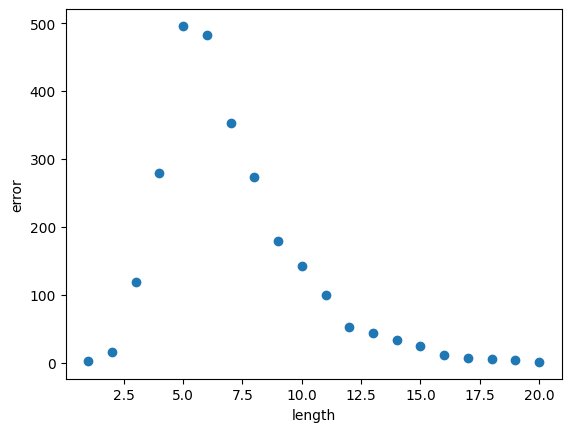

vowel error =  325
correct vowel =  631
consonant error 4233
consonant correct 12053


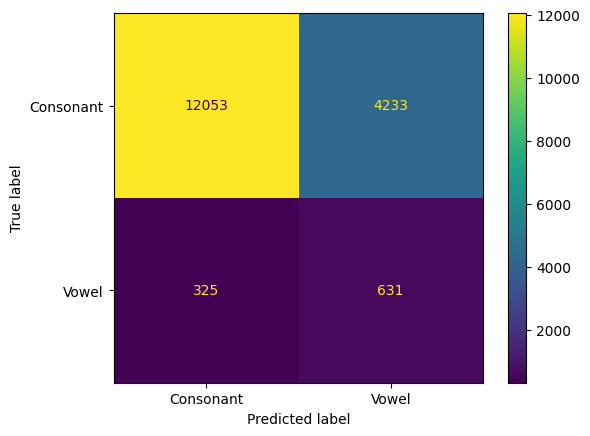

error when actual character is consonant but predicted is vowel 0.26797923524943024
error when actual character is vowel but predicted is consonant 0.3399581589958159


(0.8692643227051183, 35.9619140625)

In [106]:
evaluatetest(encoder1,decoder2,df_test,batchsize)

In [ ]:
def heatmap(encoder,decoder,dataset,batchsize):
    loss_total = 0
    accu_total = 0
    input_batch = []
    target_batch = []
    encoder.eval()
    decoder.eval()
    criterion = nn.CrossEntropyLoss()
    attn_wtlist = []
    english_words = list(dataset['X'])
    hindi_words = list(dataset['y'])

    imax = 30

    for i in range(len(english_words_test)):
        for j in range(imax - len(english_words_test[i])):
            english_words_test[i] = english_words_test[i] + '-'
    input_tensor = [tensorFromWord(lang_input,word) for word in english_words_test]
    output_tensor = [tensorFromWord(lang_output,word) for word in hindi_words_test]

    
    
    for i in range(0,len(english_words),batchsize):
        if i + batchsize > len(english_words):
            break
        input_batch.append(nn.utils.rnn.pad_sequence(input_tensor[i:i + batchsize]).squeeze(2).to(device)) #maxlength,batchsize,1
        target_batch.append(nn.utils.rnn.pad_sequence(output_tensor[i:i + batchsize]).squeeze(2).to(device)) #maxlength,batch

    
    loss = 0
    for batchnum in range(len(input_batch)):
        hidden = encoder.initHidden()
        cell = hidden
        encoder_hidden = (hidden, cell)
    
        input_length = input_batch[batchnum].size(0)
        target_length = target_batch[batchnum].size(0)
    
        encoder_output, encoder_hidden = encoder(
            input_batch[batchnum], encoder_hidden)
        decoder_input = torch.tensor([SOW_token] * batchsize, device=device)

        
        
        d_hidden = torch.zeros(decoder.num_layers, decoder.batchsize, decoder.hidden_size, device = device)
        d_cell = torch.zeros(decoder.num_layers, decoder.batchsize, decoder.hidden_size, device = device)
        (hidden, cell) = encoder_hidden 
        if encoder.num_layers != decoder.num_layers:
            d_hidden[:,:,:] = hidden[encoder.num_layers - 1,:,:]
            if cell != None:
                d_cell[:,:,:] = cell[encoder.num_layers - 1,:,:]
            else :
                d_cell = cell
        else :
            d_hidden = hidden
            d_cell = cell
        if d_cell == None and decoder.modelname == 'LSTM':
            d_cell = d_hidden
        decoder_hidden = (d_hidden , d_cell)

        decoder_words = []
        for di in range(target_length):
            decoder_output, decoder_hidden,attn_weights = decoder(
                decoder_input, decoder_hidden,encoder_output)
            if batchnum == 0:
                attn_wtlist.append(attn_weights)
            loss += criterion(decoder_output, target_batch[batchnum][di])
            topv, topi = decoder_output.topk(1)

            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_words.append(topi.squeeze().detach().view(1,-1))

        accu = accuracy(decoder_words,target_batch[batchnum])
    
        loss = loss.item() / target_length
        loss_total += loss * batchsize
        accu_total += accu
    loss_total = loss_total/len(english_words)
    accu_total = (accu_total * 100)/(len(input_batch) * batchsize)
    encoder.train()
    decoder.train()
    
    attn_wtlist = torch.stack(attn_wtlist)
    
    attn_wtlist = torch.permute(attn_wtlist,(1,2,0))
    attn_wtlist = attn_wtlist[:9,:,:].cpu().detach().numpy()
    xlabel = list(list(x) for x in df_test['X'][:9])
    ylabel = list(list(x) for x in df_test['y'][:9])
    fig,axs = plt.subplots(3,3,figsize = (20,20))
    for itr in range(0,9):
        ax = axs[itr // 3, itr % 3]
        
        data = attn_wtlist[itr,:len(xlabel[itr]),:len(ylabel[itr])]
#         print('h',data.shape)
        hindi_font = fm.FontProperties(fname="/kaggle/input/hinfont/Nirmala.ttf")
        sns.heatmap(data,cmap='viridis',ax = ax,cbar = True,cbar_kws = {'label':'Value'})
        rows,cols = data.shape
#         print(rows ,cols, len(xlabel[itr]))
#         print
        ax.set_yticks(np.arange(rows) + 0.5)
        ax.set_yticklabels(xlabel[itr])
        ax.set_xticks(np.arange(cols) +0.5)
        ax.set_xticklabels(ylabel[itr],fontproperties = hindi_font)
#         print(xlabel[itr])
        cbar = ax.collections[0].colorbar
        cbar.set_label('Value')
        fig.savefig("ex.png")
        temp = plt.imread("ex.png")
#         plot.append(temp)
    plt.tight_layout()
    plt.show()
    return loss_total,accu_total


In [27]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'ACCURACY VS EPOCH',
    'metric': {
        'goal': 'maximize', 
        'name': 'validation_accuracy'
        },
    'parameters': {
        'embeddingsize' : {'values' : [128,256,512]},
        'number_of_encoder_layers' : {'values' : [2,3]},
        'number_of_decoder_layers' : {'values' : [2,3]},
        'hidden_size' : {'values' : [256]},

        'learning_rate': {'values':[0.001,0.0001]},
        'beta' : {'values' : [0,0.9]},
        'optimizer' : {'values' : ['Adam']},
        
        'batchsize': {'values': [128,256,512]},
        'bidirectional' : {'values' : [True,False]},
        'n_iters': {'values': [15,20,30,40]},
        'loss' : {'values' : ['cross_entropy']},
        'encodermodelname' : {'values' : ['GRU','LSTM']},
        'decodermodelname' : {'values' : ['GRU','LSTM']},
        'drop_out' : {'values' : [0.2,0.3]}
       }
    }

In [ ]:
def withattention():
    '''
    main function which runs sweep
    '''
    
    wandb.init(project = 'Assignment 3')
    config = wandb.config
    encoder = EncoderRNN(lang_input.n_chars,config.hidden_size ,config.drop_out,config.number_of_encoder_layers,config.batchsize,config.embeddingsize,config.bidirectional,config.encodermodelname).to(device)

    attndecoder = AttnDecoderRNN(config.hidden_size,lang_output.n_chars ,config.drop_out,config.number_of_decoder_layers,config.batchsize,config.embeddingsize,config.decodermodelname).to(device)
    run_name = "es_{}_nenl_{}_ndel_{}_hs_{}_lr_{}_bt_{}_o_{}_bs_{}_bi_{}_n_iters_{}_loss_{}_emn_{}_dmn_{}_do_{}".format(config.embeddingsize,config.number_of_encoder_layers,config.number_of_decoder_layers,config.hidden_size,config.learning_rate,config.beta,config.optimizer,config.batchsize,config.bidirectional,config.n_iters,config.loss,config.encodermodelname,config.decodermodelname,config.drop_out)
    print("run name - ", run_name)
    wandb.run.name = run_name
    trainIters(encoder, attndecoder, config.n_iters, config.learning_rate, config.batchsize,config.optimizer,config.beta)
    print("AFTER TRAINING - ")
    print("validation accuracy" , evaluate(encoder,attndecoder,df_valid,config.batchsize))

In [ ]:
sweep_id = wandb.sweep(sweep = sweep_configuration , project = 'Assignment 3')

wandb.agent(sweep_id , function = withattention , count = 18)